## __Import libraries__

In [1]:
main_folder_path = '../../../'

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Transform google open buildings's geometry
from shapely import wkt

# Correlation calc
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(main_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## __Notebook config__

In [78]:
city = 'Merida'
projected_crs = 'EPSG:32616' #Mérida
# Directory where output files are saved
save_output = True
map_output_dir = str(main_folder_path) + f"data/processed/temperature_2025_check/built_area/"

## __Create area of interest__

In [4]:
# Load city's hex res 8
hex_schema = 'hexgrid'
hex_table = 'hexgrid_8_city_2020'
hex_type = 'urban'

hex_query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"city\" LIKE \'{city}\' AND \"type\" LIKE \'{hex_type}\'"
hex_gdf = aup.gdf_from_query(hex_query, geometry_col='geometry')

# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

EPSG:4326
(718, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,8845098099fffff,"POLYGON ((-89.45301 20.81926, -89.44854 20.821...",31002,Acanceh,Merida,urban
1,88450980d9fffff,"POLYGON ((-89.45762 20.7967, -89.45316 20.7992...",31002,Acanceh,Merida,urban


EPSG:4326
(1, 6)


<Axes: >

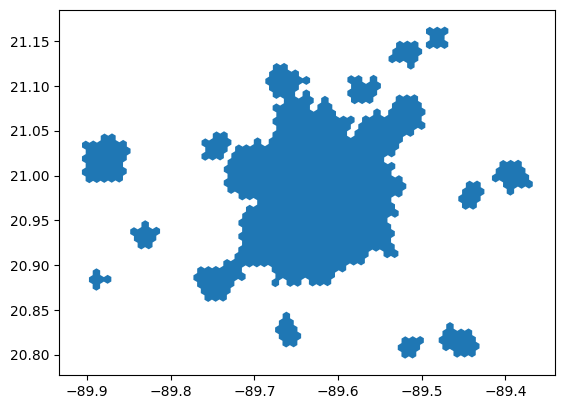

In [5]:
aoi = hex_gdf.dissolve()

# Show
print(aoi.crs)
print(aoi.shape)
aoi.plot()

## __Find all blocks within reach of area of interest__

#### Load city's blocks

In [6]:
# Create a list from a list with all unique cvegeo_mun ('CVE_ENT'+'CVE_MUN') of current city
cvegeo_mun_lst = list(hex_gdf.CVEGEO.unique())

# Load city municipality's blocks
blocks_schema = 'marco'
blocks_table = 'mza_2020'

blocks_gdf = gpd.GeoDataFrame()
for cvegeo_mun in cvegeo_mun_lst:
    
    blocks_query = f"SELECT * FROM {blocks_schema}.{blocks_table} WHERE \"CVEGEO\" LIKE \'{cvegeo_mun}%\'"
    mun_blocks_gdf = aup.gdf_from_query(blocks_query, geometry_col='geometry')
    blocks_gdf = pd.concat([blocks_gdf,mun_blocks_gdf])
    
# Show
print(blocks_gdf.crs)
print(blocks_gdf.shape)
blocks_gdf.head(2)

EPSG:4326
(23145, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,3100200110053013,31,002,0011,0053,013,Rural,Típica,"POLYGON ((-89.44142 20.88801, -89.43981 20.887..."
1,3100200100053006,31,002,0010,0053,006,Rural,Típica,"POLYGON ((-89.49854 20.88024, -89.49779 20.879..."


#### Blocks that touch area of interest

In [7]:
# Keep blocks that touch the area of interest
aoi_union = aoi.union_all()  # Create shapely object
blocks_aoi_gdf = blocks_gdf[blocks_gdf.intersects(aoi_union)].copy()

# Show
print(blocks_aoi_gdf.crs)
print(blocks_aoi_gdf.shape)
blocks_aoi_gdf.head(2)

EPSG:4326
(21277, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
3,3100200010091008,31,002,0001,0091,008,Urbana,Típica,"POLYGON ((-89.44926 20.81246, -89.44917 20.812..."
4,3100200010034011,31,002,0001,0034,011,Urbana,Típica,"POLYGON ((-89.45417 20.81256, -89.45408 20.812..."


<Axes: >

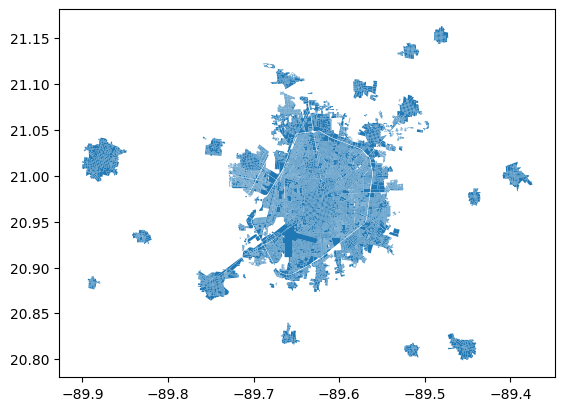

In [8]:
blocks_aoi_gdf.plot()

## __Load google buildings__

In [9]:
# Load csv
buildings_df = pd.read_csv(main_folder_path+'data/external/google_open_buildings/8f5_buildings.csv')
# Turn into GeoDataFrame
buildings_df['geometry'] = buildings_df['geometry'].apply(wkt.loads)
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry='geometry', crs='EPSG:4326')
del buildings_df

# Show
print(buildings_gdf.crs)
print(buildings_gdf.shape)
buildings_gdf.head(2)

EPSG:4326
(3244124, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,20.913590,-89.743828,71.6770,0.7033,"POLYGON ((-89.74381 20.91354, -89.74378 20.913...",76GGW774+CFMG
1,21.150262,-88.165895,20.3107,0.6709,"POLYGON ((-88.16587 21.15028, -88.1659 21.1502...",76HH5R2M+4J5F


## __Filter for google buildings within reach of blocks (located within area of interest)__

### Filter

In [10]:
# Spatial join between buildings and blocks
buildings_aoi_gdf = gpd.sjoin(buildings_gdf, blocks_aoi_gdf, how='inner', predicate='intersects')
# Drop extra cols
buildings_aoi_gdf = buildings_aoi_gdf.drop(columns=['index_right'])

# Show
print(buildings_aoi_gdf.crs)
print(buildings_aoi_gdf.shape)
buildings_aoi_gdf.head(2)

EPSG:4326
(987761, 14)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
7,21.023225,-89.879738,19.8499,0.8195,"POLYGON ((-89.87971 21.02324, -89.87975 21.023...",76HG24FC+74JV,310380001008A022,31,038,0001,008A,022,Urbana,Típica
10,20.916671,-89.624195,13.1274,0.6835,"POLYGON ((-89.62418 20.91665, -89.62418 20.916...",76GGW98G+M87X,3105000015121016,31,050,0001,5121,016,Urbana,Típica


### Remove duplicated blocks (Which happens whenever a building touches two or more blocks)

#### __SHOW__ - Buildings that touch two or more blocks test

In [30]:
buildings_aoi_gdf.loc[buildings_aoi_gdf.full_plus_code.duplicated()]

,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
175,21.000608,-89.648010,228.2214,0.7898,"POLYGON ((-89.64791 21.00063, -89.64805 21.000...",76HG2922+6QX8,3105000011913044,31,050,0001,1913,044,Urbana,Típica
2295,20.987470,-89.704474,58.6492,0.8392,"POLYGON ((-89.70442 20.98746, -89.70448 20.987...",76GGX7PW+X6JX,310500001683A043,31,050,0001,683A,043,Urbana,Típica
6075,20.880707,-89.757533,36.7019,0.8416,"POLYGON ((-89.75749 20.8807, -89.75752 20.8807...",76GGV6JR+7XP9,3110100010189033,31,101,0001,0189,033,Urbana,Típica
8026,21.062817,-89.663447,288.1735,0.7881,"POLYGON ((-89.66336 21.06274, -89.66338 21.062...",76HG387P+4JFP,3105000016914017,31,050,0001,6914,017,Urbana,Típica
11554,21.027194,-89.683598,107.3897,0.7670,"POLYGON ((-89.68353 21.02721, -89.68361 21.027...",76HG28G8+VHCQ,3105000016793013,31,050,0001,6793,013,Urbana,Típica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229510,21.028567,-89.688209,33.1412,0.6929,"POLYGON ((-89.68817 21.02857, -89.68819 21.028...",76HG28H6+CPFM,3105000016793026,31,050,0001,6793,026,Urbana,Típica
3236179,21.059086,-89.610367,6.2986,0.7245,"POLYGON ((-89.61035 21.05908, -89.61036 21.059...",76HG395Q+JVJF,3105000014960022,31,050,0001,4960,022,Urbana,Típica
3236271,21.045187,-89.662387,46.1652,0.8245,"POLYGON ((-89.66234 21.04517, -89.66237 21.045...",76HG28WQ+32HG,3105000016098001,31,050,0001,6098,001,Urbana,Típica
3237889,20.981693,-89.706403,44.2843,0.7968,"POLYGON ((-89.70636 20.98169, -89.70639 20.981...",76GGX7JV+MCHJ,3105000014462007,31,050,0001,4462,007,Urbana,Típica


In [31]:
buildings_test = buildings_aoi_gdf.loc[buildings_aoi_gdf.full_plus_code=='76HG2922+6QX8'].copy()
buildings_test

,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
175,21.000608,-89.64801,228.2214,0.7898,"POLYGON ((-89.64791 21.00063, -89.64805 21.000...",76HG2922+6QX8,3105000011913030,31,050,0001,1913,030,Urbana,Típica
175,21.000608,-89.64801,228.2214,0.7898,"POLYGON ((-89.64791 21.00063, -89.64805 21.000...",76HG2922+6QX8,3105000011913044,31,050,0001,1913,044,Urbana,Típica


In [32]:
touched_blocks = ['3105000011913030','3105000011913044']
blocks_test = blocks_aoi_gdf.loc[blocks_aoi_gdf.CVEGEO.isin(touched_blocks)].copy()
blocks_test

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
10353,3105000011913044,31,050,0001,1913,044,Urbana,Típica,"POLYGON ((-89.64817 21.00059, -89.64877 21.000..."
10406,3105000011913030,31,050,0001,1913,030,Urbana,Típica,"POLYGON ((-89.64795 21.00051, -89.64769 21.001..."


<Axes: >

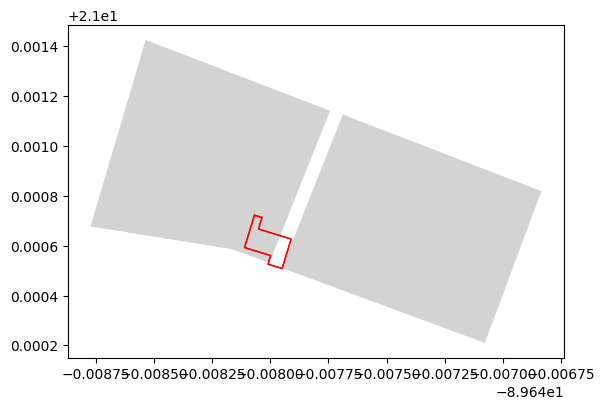

In [33]:
fig,ax=plt.subplots()

buildings_test.plot(ax=ax,
                    facecolor="none",
                    edgecolor='red',
                    zorder=1)
blocks_test.plot(ax=ax,
                 color='lightgrey',
                 zorder=0)

#### __REMOVE__

In [11]:
buildings_aoi_gdf_f = buildings_aoi_gdf.copy()
buildings_aoi_gdf_f.drop_duplicates('full_plus_code',inplace=True)

# Show
print(buildings_aoi_gdf_f.crs)
print(buildings_aoi_gdf_f.shape)
buildings_aoi_gdf_f.head(2)

EPSG:4326
(986036, 14)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
7,21.023225,-89.879738,19.8499,0.8195,"POLYGON ((-89.87971 21.02324, -89.87975 21.023...",76HG24FC+74JV,310380001008A022,31,038,0001,008A,022,Urbana,Típica
10,20.916671,-89.624195,13.1274,0.6835,"POLYGON ((-89.62418 20.91665, -89.62418 20.916...",76GGW98G+M87X,3105000015121016,31,050,0001,5121,016,Urbana,Típica


## __Use area to define whether a building is located in a given block or in another (Solves those duplicated buildings above)__

#### Find buildings that touch two or more blocks

In [13]:
# Overlay buildings with blocks
# (This spatial intersection, creates split buildings with data from the original building and the block it falls in)
buildings_blocks_overlay = gpd.overlay(df1=buildings_aoi_gdf_f[['full_plus_code','geometry']], df2=blocks_aoi_gdf, how="intersection")

# From that overlay, select duplicated buildings (keep=False to keep all duplicated entities)
dup_buildings = buildings_blocks_overlay.loc[buildings_blocks_overlay.full_plus_code.duplicated(keep=False)].copy()

# Show
print(dup_buildings.crs)
print(dup_buildings.shape)
dup_buildings.head(2)

EPSG:4326
(3403, 10)


,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
57,76HG2922+6QX8,3105000011913044,31,050,0001,1913,044,Urbana,Típica,"POLYGON ((-89.648 21.00056, -89.64811 21.00059..."
58,76HG2922+6QX8,3105000011913030,31,050,0001,1913,030,Urbana,Típica,"POLYGON ((-89.64795 21.00051, -89.64795 21.000..."


#### Keep building code assigned to CVEGEO of block where most of the building is located

In [14]:
# Calculate the building's area falling in any given block
dup_buildings = dup_buildings.to_crs(projected_crs)
dup_buildings['area_mza'] = dup_buildings.geometry.area
dup_buildings = dup_buildings.to_crs("EPSG:4326")

# For all duplicated buildings, keep the one with the biggest area
idx_max_area = dup_buildings.groupby("full_plus_code")["area_mza"].idxmax()
dominant_block_gdf = dup_buildings.loc[idx_max_area]

# Keep building_id and block_id relation, drop other cols
dominant_block_gdf = dominant_block_gdf[['full_plus_code','CVEGEO','geometry']]

# Show
dominant_block_gdf

,full_plus_code,CVEGEO,geometry
251719,76GGR8MQ+QX88,3105001116295002,"POLYGON ((-89.66009 20.83445, -89.65996 20.834..."
297093,76GGRF3J+WMPW,3109000010041028,"POLYGON ((-89.51832 20.80482, -89.51832 20.804..."
793818,76GGRF3J+XV3M,3109000010041024,"POLYGON ((-89.51782 20.80487, -89.51785 20.804..."
707988,76GGRF4P+GCQH,3109000010041013,"POLYGON ((-89.51394 20.80632, -89.51393 20.806..."
556538,76GGRG2X+PJWP,3100200010091024,"POLYGON ((-89.45091 20.80182, -89.45095 20.801..."
...,...,...,...
542157,76HG485X+426W,3105000930135006,"POLYGON ((-89.65256 21.10786, -89.65249 21.107..."
789156,76HG486X+6434,3105000930135002,"POLYGON ((-89.65235 21.11056, -89.6523 21.1106..."
460941,76HG4C2G+5GGW,3105000774392026,"POLYGON ((-89.57369 21.10055, -89.57362 21.100..."
459331,76HG4C2G+5H35,3105000774392018,"POLYGON ((-89.57352 21.10031, -89.57363 21.100..."


#### Graphic example

<Axes: >

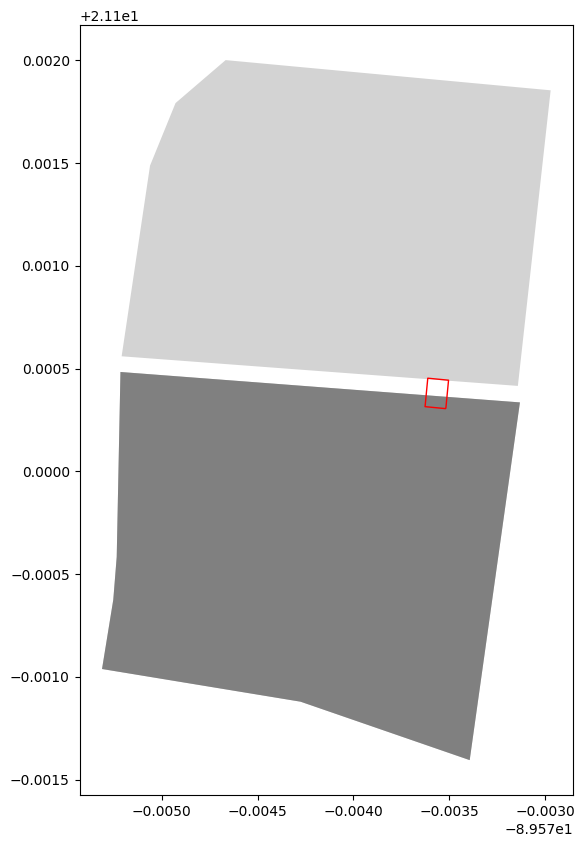

In [15]:
# DOMINANT BLOCK EXAMPLE

# From dominant_block_gdf, one example building code
building_code_example = '76HG4C2G+5H35'
# Dominant block
dominant_block_example = dominant_block_gdf.loc[dominant_block_gdf.full_plus_code==building_code_example]['CVEGEO'].unique()[0]
# Other blocks
touched_blocks_lst_example = list(buildings_blocks_overlay.loc[buildings_blocks_overlay.full_plus_code==building_code_example]['CVEGEO'].unique())

# Plot example
fig,ax = plt.subplots(figsize=(10,10))
# Plot example building
buildings_aoi_gdf_f.loc[buildings_aoi_gdf_f.full_plus_code==building_code_example].plot(ax=ax,
                                                                                        facecolor="none",
                                                                                        edgecolor='red',
                                                                                        zorder=2)
# Plot example dominant block
blocks_aoi_gdf.loc[blocks_aoi_gdf.CVEGEO==dominant_block_example].plot(ax=ax,
                                                                   color='grey',
                                                                   zorder=1)

# Plot other blocks the example building touches
blocks_aoi_gdf.loc[blocks_aoi_gdf.CVEGEO.isin(touched_blocks_lst_example)].plot(ax=ax,
                                                                                color='lightgrey',
                                                                                zorder=0)

#### Filter those buildings's data in buildings_aoi_gdf_f keeping the one with the dominant CVEGEO

In [16]:
# For those dominant, replace CVEGEOs assigned to buildings in buildings_aoi_gdf_f 
# (On buildings_aoi_gdf_f duplicates were dropped, so CVEGEOs assigned to buildings that touch one or more blocks are random)
buildings_aoi_gdf_f_2 = buildings_aoi_gdf_f.copy()

for building_id in list(dominant_block_gdf.full_plus_code.unique()):
    # Retrieve found dominant CVEGEO
    dominant_CVEGEO = dominant_block_gdf.loc[dominant_block_gdf.full_plus_code==building_id].CVEGEO.unique()[0]
    # Rewrite currently assigned CVEGEO (random) with confirmed dominant CVEGEO
    idx = buildings_aoi_gdf_f_2.full_plus_code==building_id
    buildings_aoi_gdf_f_2.loc[idx,'CVEGEO'] = dominant_CVEGEO

# Show
print(buildings_aoi_gdf_f_2.crs)
print(buildings_aoi_gdf_f_2.shape)
buildings_aoi_gdf_f_2.head(2)

EPSG:4326
(986036, 14)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
7,21.023225,-89.879738,19.8499,0.8195,"POLYGON ((-89.87971 21.02324, -89.87975 21.023...",76HG24FC+74JV,310380001008A022,31,038,0001,008A,022,Urbana,Típica
10,20.916671,-89.624195,13.1274,0.6835,"POLYGON ((-89.62418 20.91665, -89.62418 20.916...",76GGW98G+M87X,3105000015121016,31,050,0001,5121,016,Urbana,Típica


## __Find built percentage by block__

#### Dissolve buildings by block and calculate built area

In [82]:
# Change to projected crs
buildings_aoi_gdf_f_2.to_crs(projected_crs, inplace=True)
# Dissolve buildings
buildings_diss = buildings_aoi_gdf_f_2.dissolve(by='CVEGEO')
buildings_diss.reset_index(inplace=True)
# Calculate built area
buildings_diss['built_area'] = buildings_diss.geometry.area
# Keep columns of interest
buildings_diss = buildings_diss[['full_plus_code','built_area','CVEGEO','geometry']]

# Show
print(buildings_diss.crs)
print(buildings_diss.shape)
buildings_diss.head(2)

EPSG:32616
(20891, 4)


,full_plus_code,built_area,CVEGEO,geometry
0,76GGRG7V+8PF6,4000.039973,3100200010034001,"MULTIPOLYGON (((244255.763 2303426.538, 244262..."
1,76GGRG7W+82C3,1746.815880,3100200010034002,"MULTIPOLYGON (((244420.569 2303393.689, 244421..."


#### Retrieve blocks area

In [88]:
# Calculate block's area
blocks_area_gdf = blocks_aoi_gdf.copy()
blocks_area_gdf.to_crs(projected_crs,inplace=True)
blocks_area_gdf['blocks_area'] = blocks_area_gdf.geometry.area
blocks_area_gdf = blocks_area_gdf[['CVEGEO','blocks_area','geometry']]

# Merge with built area gdf
pctbuilt_block_df = pd.merge(buildings_diss[['full_plus_code','built_area','CVEGEO']], blocks_area_gdf, on='CVEGEO')
pctbuilt_block_gdf = gpd.GeoDataFrame(pctbuilt_block_df,
                                      crs=projected_crs,
                                      geometry='geometry')

# Show
print(pctbuilt_block_gdf.crs)
print(pctbuilt_block_gdf.shape)
pctbuilt_block_gdf.head(2)

EPSG:32616
(20891, 5)


,full_plus_code,built_area,CVEGEO,blocks_area,geometry
0,76GGRG7V+8PF6,4000.039973,3100200010034001,18707.663088,"POLYGON ((244412.648 2303389.749, 244273.884 2..."
1,76GGRG7W+82C3,1746.815880,3100200010034002,5580.407754,"POLYGON ((244482.584 2303457.277, 244489.331 2..."


#### Calculate built percentage

In [92]:
# Calculate build percentage
pctbuilt_block_gdf['built_pct'] = (pctbuilt_block_gdf['built_area'] / pctbuilt_block_gdf['blocks_area'])*100

# Show
print(pctbuilt_block_gdf.crs)
print(pctbuilt_block_gdf.shape)
pctbuilt_block_gdf.head(2)

EPSG:32616
(20891, 6)


,full_plus_code,built_area,CVEGEO,blocks_area,geometry,built_pct
0,76GGRG7V+8PF6,4000.039973,3100200010034001,18707.663088,"POLYGON ((244412.648 2303389.749, 244273.884 2...",21.381826
1,76GGRG7W+82C3,1746.815880,3100200010034002,5580.407754,"POLYGON ((244482.584 2303457.277, 244489.331 2...",31.302657


Text(0.5, 1.0, 'Percentage of built area (Google Buildings) in Merida by block.')

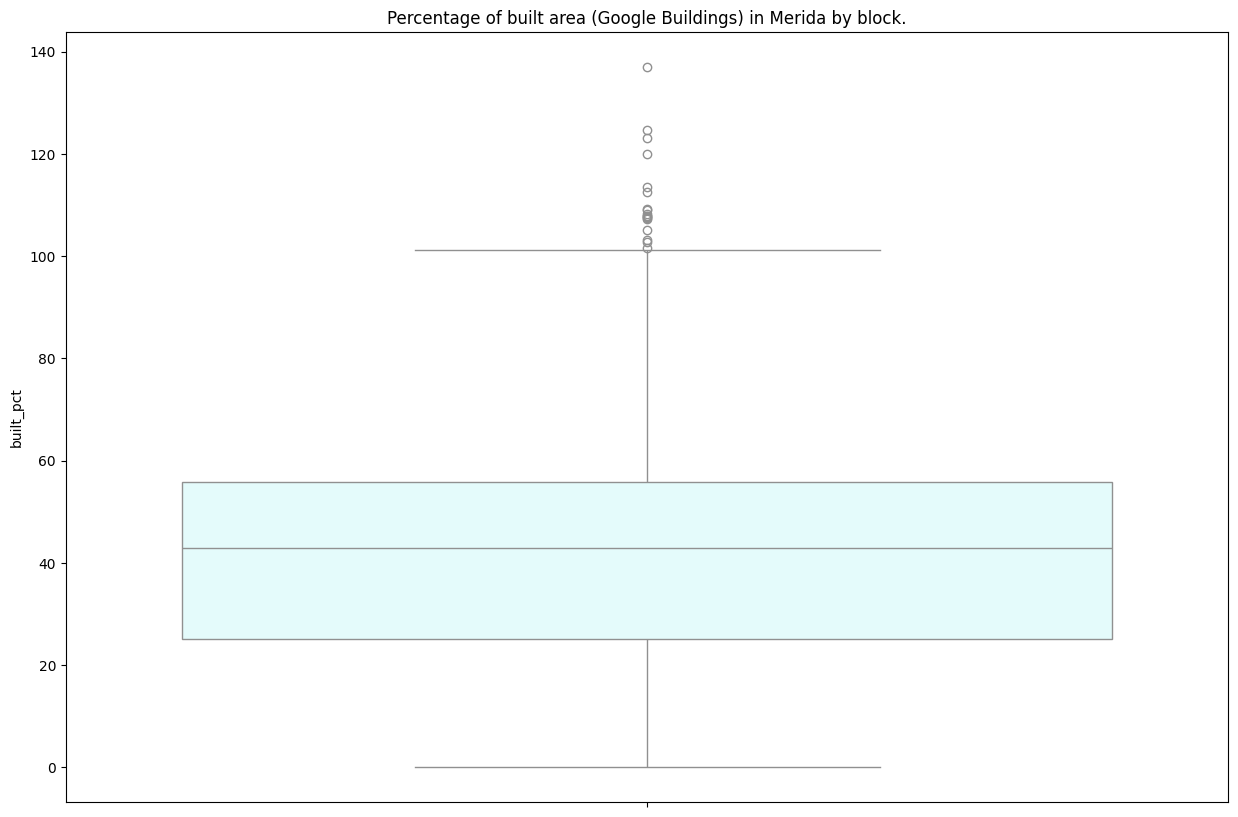

In [93]:
fig,ax=plt.subplots(figsize=(15,10))
sns.boxplot(pctbuilt_block_gdf.built_pct,
            color='lightcyan',
            zorder=0,
            ax=ax)
ax.set_title(f'Percentage of built area (Google Buildings) in {city} by block.')

#### Graphic example

In [95]:
a="""
# MORE THAN 100% BUILT EXAMPLE
max_built_pct = float(pctbuilt_block_gdf.built_pct.max())
print(f"Showing block with maximum built percentage: {max_built_pct}%.")

# Buildings assigned to block that has max built percentage
max_buildings = pctbuilt_block_gdf.loc[pctbuilt_block_gdf.built_pct==max_built_pct]
# Block to which those buildings are assigned to
max_cvegeo = max_buildings.CVEGEO.unique()[0]
max_block = blocks_area_gdf.loc[blocks_area_gdf.CVEGEO==max_cvegeo]

# Plot example
fig,ax = plt.subplots(figsize=(10,10))
# Plot max buildings
max_buildings.plot(ax=ax,
                   facecolor="none",
                   edgecolor='red',
                   zorder=2)
# Plot max block
max_block.plot(ax=ax,
               color='lightgrey',
               zorder=0)"""

#### Substitute all values above 100% with 100% built percentage

In [96]:
idx = pctbuilt_block_gdf.built_pct>=100
pctbuilt_block_gdf.loc[idx,'built_pct'] = 100

# Show
print(float(pctbuilt_block_gdf.built_pct.max()))
pctbuilt_block_gdf.head(2)

100.0


,full_plus_code,built_area,CVEGEO,blocks_area,geometry,built_pct
0,76GGRG7V+8PF6,4000.039973,3100200010034001,18707.663088,"POLYGON ((244412.648 2303389.749, 244273.884 2...",21.381826
1,76GGRG7W+82C3,1746.815880,3100200010034002,5580.407754,"POLYGON ((244482.584 2303457.277, 244489.331 2...",31.302657


<Axes: >

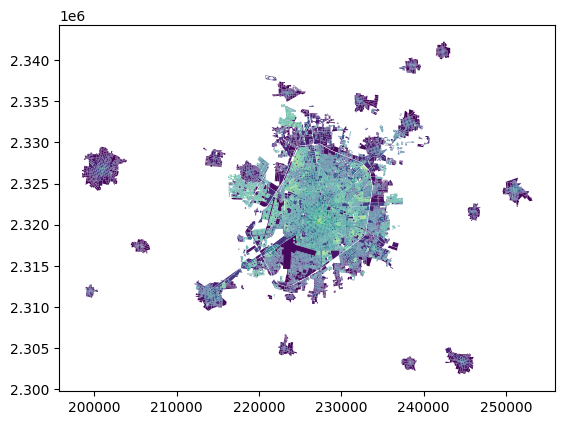

In [97]:
pctbuilt_block_gdf.plot('built_pct')

## __Save blocks with built percentage data__

In [99]:
if save_output:
    pctbuilt_block_gdf.to_file(map_output_dir + f"/{city}_builtarea_byblock.gpkg")